# 📓 Notebook 01: Data Preparation
# Goal: Load and parse scraped soccer injury dataset into a clean DataFrame
# Steps:
#  1. Load raw injury dataset (transfermarkt + L'Equipe scraped data)
#  2. Convert raw list-of-lists format into structured table
#  3. Standardize column names and formats
#  4. Save clean dataset to /data/processed for later steps

In [3]:
# 📦 Libraries
# pandas, numpy  → Data handling and numerical operations
# requests, BeautifulSoup → Web scraping player/injury data
# sklearn → Machine learning (Random Forest, scaling, model evaluation)
# imblearn.SMOTE → Handle class imbalance by oversampling minority class
# matplotlib, seaborn → Visualization (EDA, performance plots)
# utilities: ast, operator, itertools, Counter, time, warnings


In [1]:
# Necessary libraries
#Libraries used in this notebook , they will be repeated for clairty in the notebook aswell
import pandas as pd
import ast
import requests
from bs4 import BeautifulSoup
import numpy as np
import operator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score
import time

import matplotlib.pyplot as plt
import seaborn as sns
#Hide Warnings
import warnings
warnings.filterwarnings('ignore')


# Step 1 : Data Prep

## Load data in .
Sourced from kaagle at https://www.kaggle.com/datasets/eliesemmel/soccerplayersinjuries . DF contains injuries from the top 5 leagues scraped from transfermarket.com and l'equipe

In [2]:
# File path
file_path = 'C:\\Users\\Dell\\OneDrive\\Desktop\\Final-player.txt'

# Open the file for reading with UTF-8 encoding
with open(file_path, 'r', encoding='utf-8') as file:
    content = file.read()

# convert it to a Python object
data = ast.literal_eval(content)

# Extract the data into a format suitable for DataFrame
# Initialise an empty list to hold the parsed data
parsed_data = []

In [3]:
# Iterate through each row in the data
for row in data:
    # Unpack the row into individual variables
    player_id, name, club, club_value, birth, weight, height, country, role, foot, transfers, injuries = row
    
    # Convert the list of transfers into a string format
    transfers_str = ', '.join([f'{x[0]} -> {x[1]}, {x[2]}, {x[3]}' for x in transfers])
    
    # Convert the list of injuries into a string format
    injuries_str = ', '.join([f'{x[0]}, {x[1]}, {x[2]}' for x in injuries])
    
    # Append the parsed row to the parsed_data list
    parsed_data.append([player_id, name, club, club_value, birth, weight, height, country, role, foot, transfers_str, injuries_str])

# Create a DataFrame
columns = ['PlayerId', 'name', 'club', 'club_value', 'birth', 'weight', 'height', 'country', 'role', 'foot', 'transfers', 'injuries']
df_soccer = pd.DataFrame(parsed_data, columns=columns)

print(df_soccer.head())

  PlayerId             name             club    club_value       birth weight  \
0   238223          Ederson  Manchester City  1,14 Bill. €  1993-08-17     89   
1    40423    Claudio Bravo  Manchester City  1,14 Bill. €  1983-04-13     84   
2   371021   Arijanet Murić  Manchester City  1,14 Bill. €  1998-11-07      -   
3   186590      John Stones  Manchester City  1,14 Bill. €  1994-05-28     69   
4   176553  Aymeric Laporte  Manchester City  1,14 Bill. €  1994-05-27     85   

  height  country                    role   foot  \
0  1,88    Brazil              Goalkeeper   left   
1  1,84     Chile              Goalkeeper  right   
2  1,98    Kosovo              Goalkeeper  right   
3  1,88   England  Defender - Centre-Back  right   
4  1,91    France  Defender - Centre-Back   left   

                                           transfers  \
0  \nBenfica  -> \nMan City , 17/18, Jul 1, 2017,...   
1  \nFC Barcelona  -> \nMan City , 16/17, Aug 25,...   
2  \nNAC Breda  -> \nMan City , 

In [4]:
df_soccer.head()

,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"\nBenfica -> \nMan City , 17/18, Jul 1, 2017,...","16/17, Meniscal Injury, 29"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...","18/19, Achilles tendon rupture, 314, 16/17, Di..."
2,371021,Arijanet Murić,Manchester City,"1,14 Bill. €",1998-11-07,-,"1,98",Kosovo,Goalkeeper,right,"\nNAC Breda -> \nMan City , 18/19, Aug 22, 20...",
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"\nEverton -> \nMan City , 16/17, Aug 9, 2016,...","18/19, Muscle Injury, 6, 17/18, Minor Knock, 4..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"\nAthletic -> \nMan City , 17/18, Jan 30, 201...","18/19, Muscle Injury, 12, 16/17, Groin Injury,..."


In [5]:
# Remove rows where the "injuries" column is blank or contains only whitespace.These dont contain any info
df_soccer = df_soccer[df_soccer['injuries'].str.strip() != '']

# Print the first few rows to verify
df_soccer.head(5)


,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,transfers,injuries
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"\nBenfica -> \nMan City , 17/18, Jul 1, 2017,...","16/17, Meniscal Injury, 29"
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...","18/19, Achilles tendon rupture, 314, 16/17, Di..."
3,186590,John Stones,Manchester City,"1,14 Bill. €",1994-05-28,69,"1,88",England,Defender - Centre-Back,right,"\nEverton -> \nMan City , 16/17, Aug 9, 2016,...","18/19, Muscle Injury, 6, 17/18, Minor Knock, 4..."
4,176553,Aymeric Laporte,Manchester City,"1,14 Bill. €",1994-05-27,85,"1,91",France,Defender - Centre-Back,left,"\nAthletic -> \nMan City , 17/18, Jan 30, 201...","18/19, Muscle Injury, 12, 16/17, Groin Injury,..."
5,54781,Nicolás Otamendi,Manchester City,"1,14 Bill. €",1988-02-12,80,"1,83",Argentina,Defender - Centre-Back,right,"\nValencia -> \nMan City , 15/16, Aug 20, 201...","15/16, Ankle problems, 7, 14/15, Ankle problem..."


In [6]:
df_soccer.describe

<bound method NDFrame.describe of      PlayerId              name             club     club_value       birth  \
0      238223           Ederson  Manchester City   1,14 Bill. €  1993-08-17   
1       40423     Claudio Bravo  Manchester City   1,14 Bill. €  1983-04-13   
3      186590       John Stones  Manchester City   1,14 Bill. €  1994-05-28   
4      176553   Aymeric Laporte  Manchester City   1,14 Bill. €  1994-05-27   
5       54781  Nicolás Otamendi  Manchester City   1,14 Bill. €  1988-02-12   
...       ...               ...              ...            ...         ...   
2573    26148    Juanjo Camacho        SD Huesca  46,80 Mill. €  1980-08-02   
2574   167721    Ezequiel Ávila        SD Huesca  46,80 Mill. €  1994-02-06   
2575   210143       Álex Gallar        SD Huesca  46,80 Mill. €  1992-03-19   
2577   256680       Juanpi Añor        SD Huesca  46,80 Mill. €  1994-01-24   
2578   459463   Cucho Hernández        SD Huesca  46,80 Mill. €  1999-04-22   

     weight heigh

The data in Injury type is currently season,injury and days out injured . It can also contain multiple lines of information( ie every injury the player occured in the timeframe. Each line of information contains two commas . This information will allow the data to be split. ie each injury will get its own row. 

In [7]:
# Split the 'injuries' column into a list where each entry is separated by a comma
df_soccer['injuries'] = df_soccer['injuries'].str.split(',')

# Define a function to reshape the list so that every three elements are grouped together
#Each injury will get its own row
def group_injuries(injuries):
    # Use list slicing to create groups of three elements
    grouped_injuries = [injuries[i:i+3] for i in range(0, len(injuries), 3)]
    return grouped_injuries

# Apply the function to the injuries column
df_soccer['injuries'] = df_soccer['injuries'].apply(group_injuries)

# Expand the list into separate rows using explode, so each injury gets its own row
df_soccer = df_soccer.explode('injuries')

# Split the 'injuries' list into separate columns (season, injury_type, days_injured) 
# Create a new DataFrame from the list and assign it back to the original DataFrame
df_soccer[['season', 'injury_type', 'days_injured']] = pd.DataFrame(df_soccer['injuries'].tolist(), index=df_soccer.index)

# Drop the original injuries column as no longer needed
df_soccer = df_soccer.drop(columns=['injuries'])

# Preview the df
df_soccer


,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,transfers,season,injury_type,days_injured
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,"\nBenfica -> \nMan City , 17/18, Jul 1, 2017,...",16/17,Meniscal Injury,29
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...",18/19,Achilles tendon rupture,314
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...",16/17,Disrupted Calf Muscle,57
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...",15/16,Calf Injury,17
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,"\nFC Barcelona -> \nMan City , 16/17, Aug 25,...",15/16,Torn muscle bundle,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,256680,Juanpi Añor,SD Huesca,"46,80 Mill. €",1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,"\nMálaga CF -> \nSD Huesca , 18/19, Jan 31, 2...",15/16,Infection,7
2577,256680,Juanpi Añor,SD Huesca,"46,80 Mill. €",1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,"\nMálaga CF -> \nSD Huesca , 18/19, Jan 31, 2...",14/15,Unknown Injury,12
2578,459463,Cucho Hernández,SD Huesca,"46,80 Mill. €",1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,"\nWatford -> \nSD Huesca , 17/18, Jul 8, 2017...",18/19,Flu,7
2578,459463,Cucho Hernández,SD Huesca,"46,80 Mill. €",1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,"\nWatford -> \nSD Huesca , 17/18, Jul 8, 2017...",17/18,Metatarsal Fracture,47


## Step 2: Injury Data Restructuring

The raw `injuries` column contains long comma-separated strings with multiple injuries per player 
(e.g. `2019/20, ACL Injury, 180 days, 2020/21, Hamstring, 45 days`).

Goal:
- Split the column so that each injury gets its own row.
- Extract `season`, `injury_type`, and `days_injured` into structured columns.
- Remove irrelevant/missing data to keep the dataset clean and focused on ACL injuries.


In [8]:
# Group by the injury_type column and count the number of occurrences
injury_table = df_soccer.groupby('injury_type').size().reset_index(name='count')

# injury_table = df_soccer.groupby('injury_type')['injury_type'].count().reset_index(name='count')

# Preview the resulting table
print(injury_table)


                   injury_type  count
0                                   2
1          Abdominal Influenza     87
2             Abdominal Strain     24
3     Abdominal muscles injury     17
4          Achilles Irritation     24
..                         ...    ...
289                 open wound      1
290    rupture of the timpanum      3
291                     sprain      5
292          tendon irritation     21
293                torn tendon     17

[294 rows x 2 columns]


### Missing values
Find rows with missing values , any row that contains ACL injury information will be retained and the information will be sourced . Rows that dont contain information regarding ACL injury will be dropped as they are surplus to requirements. 

In [9]:
# Dropping transfers as will not add any statistical value.
df_soccer.drop('transfers', axis=1, inplace=True)


In [10]:
# Display rows with NaN values
rows_with_nan = df_soccer[df_soccer.isna().any(axis=1)]
print(rows_with_nan)

     PlayerId                     name                club      club_value  \
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,50 Mill. €   
129     34322                 Sokratis          Arsenal FC  625,

In [11]:
# Filter the subset to only include rows where 'injury_type' contains the word "Cruciate"
# `str.contains` checks if each string in the Series contains the substring "Cruciate"
cruciate_injuries = rows_with_nan[rows_with_nan['injury_type'].str.contains('Cruciate', case=False, na=False)]
print("\nRows with Cruciate injuries:")
print(cruciate_injuries)


Rows with Cruciate injuries:
    PlayerId     name       club      club_value birth weight height country  \
782   129586  Kayembe  FC Nantes  100,10 Mill. €  None     73   None    None   

     role  foot  season                 injury_type days_injured  
782  None  None   17/18   Cruciate Ligament Rupture          212  


Kayemebe information can be manually inputted as there is no other entries.
Will also check for empty strings to see if there are any other missing values.

In [12]:
#  to check for empty strings
rows_with_empty_strings = df_soccer[df_soccer.applymap(lambda x: x == '').any(axis=1)]
print(rows_with_empty_strings)

Empty DataFrame
Columns: [PlayerId, name, club, club_value, birth, weight, height, country, role, foot, season, injury_type, days_injured]
Index: []


In [13]:
# As there is more non-acl injuries relative to ACL injuries , non-acl injuries with nan-values will be dropped
#Only Kayembe should remain
# Filter rows where any column has NaN
nan_rows = df_soccer[df_soccer.isna().any(axis=1)]

# Further filter rows where 'injury_type' contains 'cruciate'
filtered_rows = nan_rows[nan_rows['injury_type'].str.contains('cruciate', na=False)]

# Print those rows
print(filtered_rows)


Empty DataFrame
Columns: [PlayerId, name, club, club_value, birth, weight, height, country, role, foot, season, injury_type, days_injured]
Index: []


### Kayembe missing values

values missing are height , country , birthday , role and foot . These will be scraped from wikipedia and  transfermarket.com. 

In [14]:
print(df_soccer.loc[782])


    PlayerId     name       club      club_value birth weight height country  \
782   129586  Kayembe  FC Nantes  100,10 Mill. €  None     73   None    None   
782   129586  Kayembe  FC Nantes  100,10 Mill. €  None     73   None    None   

     role  foot  season                 injury_type days_injured  
782  None  None   17/18                 Knee Injury          449  
782  None  None   17/18   Cruciate Ligament Rupture          212  


In [15]:
#Necessary Libraries
import requests
from bs4 import BeautifulSoup

In [16]:
# Providing link for Kayemebe to be scraped
kayembe_url = 'https://en.wikipedia.org/wiki/Joris_Kayembe'

In [17]:
# Define a function to scrape information from a Wikipedia URL
def scrape_wiki(url):
    # Make an HTTP GET request to fetch the raw HTML content
    response = requests.get(url)
    
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the table with class 'infobox vcard' that contains personal information
    info_table = soup.find('table', {'class': 'infobox vcard'})
    
    # Check if the table was found
    if info_table:
        # Find all rows in the table
        rows = info_table.find_all('tr')
        
        # Initialize variables to store scraped data
        date_of_birth = ''
        place_of_birth = ''
        height = ''
        position = ''
        
        # Loop through each row to find relevant information
        for row in rows:
            th = row.find('th')  # Column header
            td = row.find('td')  # Column value
            if th and td:  # Ensure that both header and value are found
                key = th.text.strip()
                value = td.text.strip()
                
                # Extract Date of Birth
                if key == 'Date of birth':
                    dob_data = td.find('span', {'class': 'bday'})
                    if dob_data:
                        date_of_birth = dob_data.text.strip()
                    else:
                        date_of_birth_parts = value.split(' ')
                        if len(date_of_birth_parts) >= 3:
                            date_of_birth = ' '.join(date_of_birth_parts[:3])
                
                # Extract Place of Birth
                if key == 'Place of birth':
                    place_of_birth = value.split(',')[1].strip()
                
                # Extract Height and convert to cm
                if key == 'Height':
                    height_value = value.split(' ')[0].replace('m', '').strip()
                    height = int(float(height_value) * 100)
                
                # Extract Position
                if key == 'Position(s)':
                    position = value.strip()
        
        # Return the extracted data
        return date_of_birth, place_of_birth, height, position
    
    else:
        # In case the table is not found, print error message
        print(f"Couldn't find personal information for {url}")
        return None

In [18]:
result = scrape_wiki(kayembe_url)

# Check if scraping was successful
if result:
    date_of_birth, place_of_birth, height, position = result
    # Print the scraped data
    print(f"Date of Birth: {date_of_birth}")
    print(f"Place of Birth: {place_of_birth}")
    print(f"Height: {height} cm")
    print(f"Position: {position}")
    
    # Update the DataFrame 'df_soccer' for row with index 782
    df_soccer.at[782, 'birth'] = date_of_birth
    df_soccer.at[782, 'country'] = place_of_birth
    df_soccer.at[782, 'height'] = height
    df_soccer.at[782, 'role'] = position

Date of Birth: 1994-08-08
Place of Birth: Belgium
Height: 180 cm
Position: Left-back / Wing-back


In [19]:
#manually inputting foot , obtained from transfermarket.com 
df_soccer.loc[782, 'foot'] = 'left'

In [20]:
#Updated row
print(df_soccer.loc[782])


    PlayerId     name       club      club_value       birth weight height  \
782   129586  Kayembe  FC Nantes  100,10 Mill. €  1994-08-08     73    180   
782   129586  Kayembe  FC Nantes  100,10 Mill. €  1994-08-08     73    180   

     country                   role  foot  season                 injury_type  \
782  Belgium  Left-back / Wing-back  left   17/18                 Knee Injury   
782  Belgium  Left-back / Wing-back  left   17/18   Cruciate Ligament Rupture   

    days_injured  
782          449  
782          212  


The dataset does not contain any nan or empty cells now . 

## Rows with hyphens:

In [21]:
# Some rows also contain a hyphen for missing data . Similar to above , if a row contains cruciate , it will be kept

In [22]:
rows_with_hyphen = df_soccer[df_soccer.applymap(lambda x: x == '-').any(axis=1)]
print(rows_with_hyphen)

     PlayerId               name                club     club_value  \
8      340460   Philippe Sandler     Manchester City   1,14 Bill. €   
8      340460   Philippe Sandler     Manchester City   1,14 Bill. €   
8      340460   Philippe Sandler     Manchester City   1,14 Bill. €   
8      340460   Philippe Sandler     Manchester City   1,14 Bill. €   
8      340460   Philippe Sandler     Manchester City   1,14 Bill. €   
...       ...                ...                 ...            ...   
2466   248330              Chema          Levante UD  87,70 Mill. €   
2534   221321  Joaquín Fernández  Real Valladolid CF  63,80 Mill. €   
2534   221321  Joaquín Fernández  Real Valladolid CF  63,80 Mill. €   
2567   378293     Yangel Herrera           SD Huesca  46,80 Mill. €   
2567   378293     Yangel Herrera           SD Huesca  46,80 Mill. €   

           birth weight height      country                             role  \
8     1997-02-10      -  1,90   Netherlands           Defender - Ce

In [23]:
# Drop rows that dont contain cruciate
# Find rows with the word 'cruciate'
rows_with_cruciate = df_soccer[df_soccer.applymap(lambda x: 'cruciate' in str(x)).any(axis=1)]

# Find common index values
common_index = rows_with_hyphen.index.intersection(rows_with_cruciate.index)

# Extract rows that meet both conditions
rows_with_hyphen_and_cruciate = df_soccer.loc[common_index]

print("Rows with both hyphen and cruciate:")
print(rows_with_hyphen_and_cruciate)

Rows with both hyphen and cruciate:
    PlayerId          name               club      club_value       birth  \
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   

    weight height  country                      role  foot  season  \
125      -  1,83   England  Forward - Centre-Forward  left   18/19   
125      -  1,83   England  Forward - Centre-Forward  left   18/19   
125      -  1,83   England  Forward - Centre-Forward  left   16/17   
125      -  1,83   England  Forward - Centre-Forward  left   14/15   
125      -  1,83   England  Forward - Centre-Forward  left   14/15   

                     injury_type days_injured  
125                        Knock

In [24]:
# Add weight for wilson , from transfermarket.com
df_soccer.loc[125, 'weight'] = 73
print(df_soccer.loc[125])


    PlayerId          name               club      club_value       birth  \
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   
125   214104  James Wilson  Manchester United  797,50 Mill. €  1995-12-01   

    weight height  country                      role  foot  season  \
125     73  1,83   England  Forward - Centre-Forward  left   18/19   
125     73  1,83   England  Forward - Centre-Forward  left   18/19   
125     73  1,83   England  Forward - Centre-Forward  left   16/17   
125     73  1,83   England  Forward - Centre-Forward  left   14/15   
125     73  1,83   England  Forward - Centre-Forward  left   14/15   

                     injury_type days_injured  
125                        Knock            4  
125                 

In [25]:
# Find the indexes of rows where the weight column has a hyphen
indexes_to_drop = df_soccer[df_soccer['weight'] == '-'].index

# Drop those rows by index as they are no longer needed
df_soccer.drop(indexes_to_drop, inplace=True)


## Foot
Checking variables are correct. Foot should only include , left , right or both. Clearly some inccorrect data . Similar to before , any rows that dont catain cruciate will be dropped , all others with be fixed

In [26]:
unique_foot_values = df_soccer['foot'].unique()
print(unique_foot_values)

['left' 'right' 'both' None '\nEURODATA SPORT ' '\nROGON U23 '
 '\n FC Schalke 04 II ' '\nKICK & RUN SPORTS ' '\nCoaches & More GmbH '
 '\nRobert Schneider ' '\nELITE INTERNACIONAL SPORT AGENCY S.L. '
 '\n Real Sociedad ' '\n10Ten Football ']


In [27]:
#see how many cells are affected
foot_value_counts = df_soccer['foot'].value_counts()
print(foot_value_counts)


right                                       8656
left                                        2988
both                                         575
\nCoaches & More GmbH                         14
\n Real Sociedad                               6
\nEURODATA SPORT                               3
\n FC Schalke 04 II                            3
\nROGON U23                                    2
\nKICK & RUN SPORTS                            2
\n10Ten Football                               2
\nRobert Schneider                             1
\nELITE INTERNACIONAL SPORT AGENCY S.L.        1
Name: foot, dtype: int64


As only a small subset of the footedness is incorrect , they can be viewed and see what needs to be retained. The rows with the incorrect footedness and contain cruciate will be printed . All non-acl injuries will be removed .

In [28]:
#see the affected rows
values_to_search_for = [
    '\nEURODATA SPORT ', '\nROGON U23 ',
    '\n FC Schalke 04 II ', '\nKICK & RUN SPORTS ', '\nCoaches & More GmbH ',
    '\nRobert Schneider ', '\nELITE INTERNACIONAL SPORT AGENCY S.L. ',
    '\n Real Sociedad ', '\n10Ten Football '
]

rows_with_values = df_soccer[df_soccer['foot'].isin(values_to_search_for)]

print(rows_with_values)


     PlayerId                 name                 club      club_value  \
279     45882                Fabri            Fulham FC  254,00 Mill. €   
279     45882                Fabri            Fulham FC  254,00 Mill. €   
279     45882                Fabri            Fulham FC  254,00 Mill. €   
1238   336329        Nils Stendera  Eintracht Frankfurt  261,70 Mill. €   
1238   336329        Nils Stendera  Eintracht Frankfurt  261,70 Mill. €   
1284   315291          Haji Wright        FC Schalke 04  239,80 Mill. €   
1284   315291          Haji Wright        FC Schalke 04  239,80 Mill. €   
1284   315291          Haji Wright        FC Schalke 04  239,80 Mill. €   
1309   358870  Dennis Jastrzembski           Hertha BSC  203,50 Mill. €   
1309   358870  Dennis Jastrzembski           Hertha BSC  203,50 Mill. €   
1336   196421     Marvin Stefaniak        VfL Wolfsburg  176,90 Mill. €   
1336   196421     Marvin Stefaniak        VfL Wolfsburg  176,90 Mill. €   
1336   196421     Marvin 

In [29]:
#examining all unique undesired rows to see if they contain cruciate
values_to_search_for = [
    '\nEURODATA SPORT ', '\nROGON U23 ',
    '\n FC Schalke 04 II ', '\nKICK & RUN SPORTS ', '\nCoaches & More GmbH ',
    '\nRobert Schneider ', '\nELITE INTERNACIONAL SPORT AGENCY S.L. ',
    '\n Real Sociedad ', '\n10Ten Football '
]

# Filter the DataFrame to include only rows with values in the 'foot' column that match the values in values_to_search_for
filtered_df = df_soccer[df_soccer['foot'].isin(values_to_search_for)]

# Further filter the DataFrame to include only rows where the 'injury_type' column contains 'cruciate'
filtered_df_with_cruciate = filtered_df[filtered_df['injury_type'].str.contains('cruciate', case=False, na=False)]

# Print the filtered DataFrame
print(filtered_df_with_cruciate)


     PlayerId               name            club      club_value       birth  \
279     45882              Fabri       Fulham FC  254,00 Mill. €  1987-12-31   
1558   236791     Dennis Lippert  1.FC Nuremberg   52,60 Mill. €  1996-02-20   
2258   289272  Martín Merquelanz   Real Sociedad  231,70 Mill. €  1995-06-12   

     weight height  country                   role                 foot  \
279      77  1,84     Spain             Goalkeeper    \nEURODATA SPORT    
1558     63  1,72   Germany   Defender - Left-Back  \nRobert Schneider    
2258     72  1,76     Spain  Forward - Left Winger    \n Real Sociedad    

      season                 injury_type days_injured  
279    15/16   Cruciate Ligament Rupture          327  
1558   16/17   Cruciate Ligament Rupture          791  
2258   17/18   Cruciate Ligament Rupture          182  


In [30]:
#3 players affected, so manually updated. source transfermarket.com
# List of players to update
right_foot_players = ['Fabri']
left_foot_players = ['Dennis Lippert', 'Martín Merquelanz']

# Update the 'foot' value for the specified players
df_soccer.loc[df_soccer['name'].isin(right_foot_players), 'foot'] = 'right'
df_soccer.loc[df_soccer['name'].isin(left_foot_players), 'foot'] = 'left'


In [31]:
#drop all other rows as they do contain cruciate
# Create a mask that identifies rows with values in the 'foot' column that match the values in values_to_search_for
mask = df_soccer['foot'].isin(values_to_search_for)

# Invert the mask (using ~) and use it to select rows that don't match the values and drop the matching rows
df_soccer = df_soccer[~mask]
#dropped as dont include any ACL injurie

In [32]:
#verifying df
foot_value_counts = df_soccer['foot'].value_counts()
print(foot_value_counts)


right    8659
left     2991
both      575
Name: foot, dtype: int64


## League (Club country)
Find league(club country as it can be used for weather scraping later) for each club . Each club will be printed and then their wiki will be scraped  .Country is often included in the first few paragraphs . Keywords will be used to optimise the scrape.

In [33]:
# Leagues should be top 5 leagues in World football as ranked by FIFA
club_value_counts = df_soccer['club'].value_counts()
print(club_value_counts)


Bayern Munich            263
Borussia Dortmund        250
Eintracht Frankfurt      249
Hertha BSC               241
FC Augsburg              233
                        ... 
HSC Montpellier           29
FC Girondins Bordeaux     21
EA Guingamp               18
SCO Angers                15
Nîmes Olympique            8
Name: club, Length: 98, dtype: int64


Scraping wikipedia , for each clubs country . This information is often contained in the first few paragraphs. Will give key words to sort for to give league(Club country). 

Iterate over clubs in the club column and insert returned value into new column. 

In [34]:
# Import the required libraries for web scraping
import requests
from bs4 import BeautifulSoup

# Define a function to get the country of origin for a given soccer club using Wikipedia
def get_country_from_wikipedia(club_name):
    # Replace spaces with underscores because Wikipedia URLs use underscores instead of spaces
    club_name = club_name.replace(' ', '_')
    
    # Define the URL for the Wikipedia page of the club
    url = f"https://en.wikipedia.org/wiki/{club_name}"
    
    try:
        # Make an HTTP GET request to fetch the raw HTML content of the Wikipedia page
        response = requests.get(url)
        
        # Parse the HTML content using BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find and collect the first eight paragraphs from the Wikipedia page
        paragraphs = soup.find_all('p', limit=8)
        
        # Loop through each of the eight paragraphs to find a mention of the country the club belongs to
        for paragraph in paragraphs:
            text = paragraph.text
            # Check for country keywords and return the corresponding country
            if 'German' in text or 'Germany' in text:
                return 'Germany'
            elif 'Italian' in text or 'Italy' in text:
                return 'Italy'
            elif 'English' in text or 'England' in text:
                return 'England'
            elif 'France' in text or 'French' in text:
                return 'France'
            elif 'Spain' in text or 'Spanish' in text:
                return 'Spain'
    except:
        # Print an error message if the web request or parsing fails
        print(f"Failed to fetch information for {club_name}")

    # Return None if no country is found
    return None

# Get unique club names from the DataFrame 'df_soccer'
unique_clubs = df_soccer['club'].unique()

# Loop through the unique club names to get and print their countries of origin
for club in unique_clubs:
    country = get_country_from_wikipedia(club)
    print(f"Club: {club}, Country: {country}")


Club: Manchester City, Country: England
Club: Liverpool FC, Country: England
Club: Chelsea FC, Country: England
Club: Tottenham Hotspur, Country: England
Club: Manchester United, Country: England
Club: Arsenal FC, Country: England
Club: Everton FC, Country: England
Club: Leicester City, Country: England
Club: West Ham United, Country: England
Club: Crystal Palace, Country: None
Club: AFC Bournemouth, Country: Italy
Club: Fulham FC, Country: England
Club: Wolverhampton Wanderers, Country: England
Club: Southampton FC, Country: England
Club: Newcastle United, Country: England
Club: Watford FC, Country: England
Club: Brighton & Hove Albion, Country: England
Club: Burnley FC, Country: England
Club: Huddersfield Town, Country: England
Club: Cardiff City, Country: England
Club: Paris Saint-Germain, Country: France
Club: Olympique Lyon, Country: France
Club: AS Monaco, Country: France
Club: Olympique Marseille, Country: France
Club: LOSC Lille, Country: France
Club: OGC Nice, Country: France


In [35]:
# Verified that scraping worked correctly for most cases, now inputting the values into DataFrame
# create an empty dictionary to hold the mapping between club names and their countries
club_country_mapping = {}

# Loop through the list of unique clubs in df_soccer
# For each club, get the country from Wikipedia and store it in the club_country_mapping dictionary
for club in unique_clubs:
    country = get_country_from_wikipedia(club)  # Calls the previously defined function to get the country
    club_country_mapping[club] = country  # Stores the country in the dictionary, keyed by club name

# Create a new column 'club_country' in df_soccer
# Map the 'club' column to its corresponding country using the club_country_mapping dictionary
df_soccer['club_country'] = df_soccer['club'].map(club_country_mapping)

# Preview the first two rows of the modified DataFrame to ensure the new column has been added correctly
df_soccer.head(2)


,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,16/17,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,18/19,Achilles tendon rupture,314,England


In [36]:
club_country_counts = df_soccer['club_country'].value_counts()
print(club_country_counts) 


Germany    3579
Italy      2723
England    2207
Spain      2078
France     1139
Name: club_country, dtype: int64


In [37]:
# Find rows where 'club_country' is None or NaN, then get the 'club' column from those rows
missing_country_clubs = df_soccer[df_soccer['club_country'].isnull()]['club']

# Get the unique club names where the 'club_country' is missing
unique_missing_country_clubs = missing_country_clubs.unique()

# Print the unique clubs with missing 'club_country'
print(unique_missing_country_clubs)



['Crystal Palace' 'FC Girondins Bordeaux' 'FCO Dijon' '1.FC Nuremberg'
 'FC Empoli' 'RCD Espanyol Barcelona']


Crystal palace missing as the club page contains fc , not to be confused with the tourist attraction.
Espanyol, Bordeaux, Dijon and empoli also not found by default. These pages would have been difficult to find as there is other pages that could have the wiki page originally .

In [38]:
# Manually update the club_country for Crystal Palace
df_soccer.loc[df_soccer['club'] == 'Crystal Palace', 'club_country'] = 'England'

# Manually update the club_country for RCD Espanyol Barcelona
df_soccer.loc[df_soccer['club'] == 'RCD Espanyol Barcelona', 'club_country'] = 'Spain'

# Manually update the club_country for FC Girondins Bordeaux and Fc Dijon
df_soccer.loc[df_soccer['club'] == 'FC Girondins Bordeaux', 'club_country'] = 'France'
df_soccer.loc[df_soccer['club'] == 'FCO Dijon', 'club_country'] = 'France'

# Manually update the club_country for FC Empoli
df_soccer.loc[df_soccer['club'] == 'FC Empoli', 'club_country'] = 'Italy'

# Manually update the club_country for 1.FC Nuremberg
df_soccer.loc[df_soccer['club'] == '1.FC Nuremberg', 'club_country'] = 'Germany'

In [39]:
# Find clubs where 'club_country' is None or NaN
missing_country_clubs = df_soccer[df_soccer['club_country'].isnull()]['club']

# Print the clubs
print(missing_country_clubs)

Series([], Name: club, dtype: object)


In [40]:
df_soccer.head()

,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,"1,14 Bill. €",1993-08-17,89,"1,88",Brazil,Goalkeeper,left,16/17,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,18/19,Achilles tendon rupture,314,England
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,16/17,Disrupted Calf Muscle,57,England
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,15/16,Calf Injury,17,England
1,40423,Claudio Bravo,Manchester City,"1,14 Bill. €",1983-04-13,84,"1,84",Chile,Goalkeeper,right,15/16,Torn muscle bundle,24,England


## Club value

Club value contains millions and billions . convert all to millions . Drop mill and bill from column. It will be more useful if the values are all in one unit . They can then be scaled later for use in the ML models.Comma's , full stops and words will be dropped also 

In [41]:
value_counts = df_soccer['club_value'].value_counts()
print(value_counts)

772,00 Mill. €    263
602,30 Mill. €    250
261,70 Mill. €    249
203,50 Mill. €    241
113,05 Mill. €    233
                 ... 
86,15 Mill. €      29
131,55 Mill. €     21
62,45 Mill. €      18
62,75 Mill. €      15
79,45 Mill. €       8
Name: club_value, Length: 98, dtype: int64


In [42]:
# Define a function called 'convert_value' that takes a single argument 'value'.
def convert_value(value):
    # Check if 'Bill' is in the value string, indicating the value is in billions.
    if 'Bill' in value:
        # Remove commas, the ' Bill. €' and ' Mill. €' substrings from the value string.
        value = value.replace(',', '').replace(' Bill. €', '').replace(' Mill. €', '')
        # Convert the string to a float and multiply by 1000 to convert billions to millions.
        return float(value) * 1000  
    else:
        # Remove commas and the ' Mill. €' substring from the value string.
        value = value.replace(',', '').replace(' Mill. €', '')
        # Convert the cleaned string to a float.
        return float(value)

In [43]:
# Apply the 'convert_value' function to the 'club_value' column of df_soccer DataFrame.
# The result replaces the original 'club_value' column.
df_soccer['club_value'] = df_soccer['club_value'].apply(convert_value)

In [44]:
# Display the first few rows of df_soccer to verify that the 'club_value' column has been successfully converted.
df_soccer.head()

,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,16/17,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,18/19,Achilles tendon rupture,314,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,16/17,Disrupted Calf Muscle,57,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,15/16,Calf Injury,17,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,15/16,Torn muscle bundle,24,England


In [45]:
df_soccer['club_value'].describe()


count     12271.000000
mean      34621.235352
std       30066.278362
min        4245.000000
25%       12150.000000
50%       23980.000000
75%       43230.000000
max      118000.000000
Name: club_value, dtype: float64

In [46]:
# Calculate the minimum value
min_value = df_soccer['club_value'].min()

# Calculate the maximum value
max_value = df_soccer['club_value'].max()

# Calculate the median
median_value = df_soccer['club_value'].median()

# Calculate the mean
mean_value = df_soccer['club_value'].mean()

print(f"Range of values: {min_value} to {max_value}")
print(f"Median: {median_value}")
print(f"Mean: {mean_value}")
print("10th percentile:", df_soccer['club_value'].quantile(0.1))
print("90th percentile:", df_soccer['club_value'].quantile(0.9))


Range of values: 4245.0 to 118000.0
Median: 23980.0
Mean: 34621.235351642084
10th percentile: 8003.0
90th percentile: 88575.0


In [47]:
df_soccer['club_value'].dtypes

dtype('float64')

<AxesSubplot:ylabel='Frequency'>

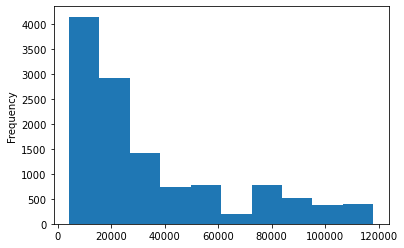

In [48]:
df_soccer['club_value'].plot(kind='hist')

<AxesSubplot:>

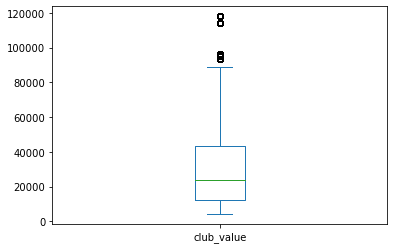

In [49]:
df_soccer['club_value'].plot(kind='box')

In [50]:
df_soccer.head(2)

,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,16/17,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,18/19,Achilles tendon rupture,314,England


## Age at start of season

Get player age at the start of the season. 

In [51]:
# Import the datetime module to work with date and time data.
import datetime

# Update the 'season' column in the df_soccer  to represent the start of each year.
# The lambda function takes each value in the 'season' column, extracts the last two digits, 
# adds '20' to it, and adds '-01-01' to represent the first day of that year.
# The apply() function applies this transformation to each value in the 'season' column.
df_soccer['season'] = df_soccer['season'].apply(lambda x: '20' + x[3:] + '-01-01')

# Display the first few rows of df_soccer DataFrame to verify that the 'season' column has been updated.
df_soccer.head()

def clean_season(season):
    # Replacing the slash with an empty string
    season = season.replace('/', '')
    # If the date is missing century (e.g., 2018), add it
    if len(season) == 6:
        season = '20' + season
    return season

In [52]:
# Apply the clean_season function to the 'season' column
df_soccer['season'] = df_soccer['season'].apply(clean_season)

# Convert the 'season' column to datetime
df_soccer['season'] = pd.to_datetime(df_soccer['season'], format='%Y-%m-%d')

# Preview the DataFrame to verify changes
df_soccer


,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,Achilles tendon rupture,314,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,Disrupted Calf Muscle,57,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Calf Injury,17,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Torn muscle bundle,24,England
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,256680,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2016-01-01,Infection,7,Spain
2577,256680,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2015-01-01,Unknown Injury,12,Spain
2578,459463,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2019-01-01,Flu,7,Spain
2578,459463,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2018-01-01,Metatarsal Fracture,47,Spain


In [53]:
# Find the range of values in the 'season' column
season_min = df_soccer['season'].min()
season_max = df_soccer['season'].max()

# Print the range
print(f"Season Range: {season_min} to {season_max}")

Season Range: 2006-01-01 00:00:00 to 2019-01-01 00:00:00


In [54]:
# Ensure no na values left
df_soccer.dropna(inplace=True)

In [55]:
df_soccer['birth'] = pd.to_datetime(df_soccer['birth'])

In [56]:
df_soccer.head(5)

,PlayerId,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country
0,238223,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,Meniscal Injury,29,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,Achilles tendon rupture,314,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,Disrupted Calf Muscle,57,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Calf Injury,17,England
1,40423,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Torn muscle bundle,24,England


In [57]:
def injury_age(season, birth):
    return season.year - birth.year

# Convert 'birth' and 'season' columns to datetime objects if they are not already
df_soccer['birth'] = pd.to_datetime(df_soccer['birth'])
df_soccer['season'] = pd.to_datetime(df_soccer['season'])

# Calculate the 'age' column
df_soccer['age'] = df_soccer.apply(lambda x: injury_age(x['season'], x['birth']), axis=1)


In [58]:
# Dropping as not needed
df_soccer = df_soccer.drop(columns=['PlayerId'])


In [59]:
df_soccer

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,Meniscal Injury,29,England,24
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,Achilles tendon rupture,314,England,36
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,Disrupted Calf Muscle,57,England,34
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Calf Injury,17,England,33
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Torn muscle bundle,24,England,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2016-01-01,Infection,7,Spain,22
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2015-01-01,Unknown Injury,12,Spain,21
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2019-01-01,Flu,7,Spain,20
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2018-01-01,Metatarsal Fracture,47,Spain,19


In [60]:
# Group by 'season' and count the number of injuries
injuries_per_season = df_soccer.groupby('season')['injury_type'].count()
injuries_per_season_df = injuries_per_season.reset_index()
injuries_per_season_df.columns = ['season', 'num_injuries']
print(injuries_per_season_df)


       season  num_injuries
0  2006-01-01             1
1  2007-01-01             3
2  2008-01-01            39
3  2009-01-01           101
4  2010-01-01           145
5  2011-01-01           280
6  2012-01-01           364
7  2013-01-01           554
8  2014-01-01           765
9  2015-01-01          1198
10 2016-01-01          1640
11 2017-01-01          2166
12 2018-01-01          2683
13 2019-01-01          2286


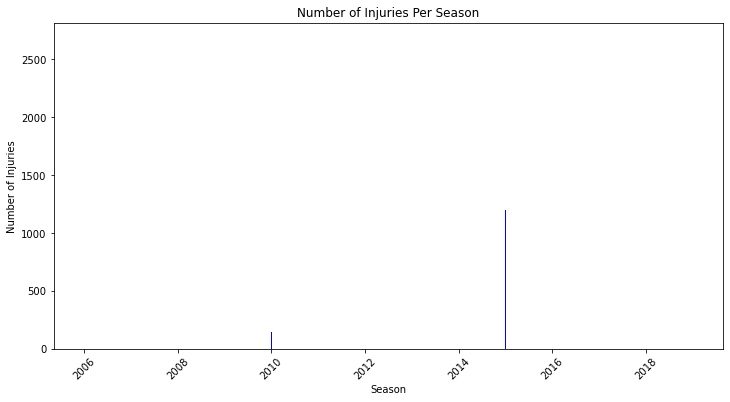

In [61]:
import matplotlib.pyplot as plt
# Group by 'season' and count the number of injuries
injuries_per_season = df_soccer.groupby('season')['injury_type'].count()

# Plotting
plt.figure(figsize=(12, 6))  # Optional: set the figure size
plt.bar(injuries_per_season.index, injuries_per_season.values, color='blue')
plt.xlabel('Season')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Per Season')
plt.xticks(rotation=45)  #  rotate the x-axis labels for better visibility
plt.show()


In [62]:
df_soccer.to_csv('df_soccer.csv', index=False)


## Rainfall

### df_acl
See ratio of ACL v non ACL

In [63]:
#df will only 
df_acl = df_soccer[df_soccer['injury_type'].str.contains('cruciate', case=False, na=False)]


In [64]:
df_acl

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2018-01-01,Cruciate Ligament Rupture,198,England,24
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2016-01-01,Cruciate Ligament Injury,52,England,22
14,Ilkay Gündogan,Manchester City,114000.0,1990-10-24,78,"1,80",Germany,Midfielder - Central Midfield,right,2017-01-01,Cruciate Ligament Rupture,241,England,27
16,Fabian Delph,Manchester City,114000.0,1989-11-21,60,"1,74",England,Midfielder - Central Midfield,left,2010-01-01,Cruciate Ligament Rupture,248,England,21
28,Joe Gomez,Liverpool FC,95050.0,1997-05-23,77,"1,88",England,Defender - Centre-Back,right,2016-01-01,Cruciate Ligament Injury,234,England,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,Bebé,Rayo Vallecano,7130.0,1990-07-12,75,"1,90",Portugal,Forward - Left Winger,right,2012-01-01,Ruptured cruciate ligament,227,Spain,22
2532,Yoel Rodríguez,Real Valladolid CF,6380.0,1988-08-28,78,"1,84",Spain,Goalkeeper,right,2017-01-01,Cruciate Ligament Rupture,214,Spain,29
2536,Nacho Martínez,Real Valladolid CF,6380.0,1989-03-07,70,"1,74",Spain,Defender - Left-Back,left,2013-01-01,Cruciate Ligament Rupture,42,Spain,24
2560,Pablo Insua,SD Huesca,4680.0,1993-09-09,75,"1,87",Spain,Defender - Centre-Back,right,2019-01-01,Cruciate Ligament Rupture,140,Spain,26


In [65]:
df_acl['injury_type'] = df_acl['injury_type'].apply(lambda x: 'ACL' if 'cruciate' in str(x).lower() else x)


In [66]:
df_acl

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2018-01-01,ACL,198,England,24
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2016-01-01,ACL,52,England,22
14,Ilkay Gündogan,Manchester City,114000.0,1990-10-24,78,"1,80",Germany,Midfielder - Central Midfield,right,2017-01-01,ACL,241,England,27
16,Fabian Delph,Manchester City,114000.0,1989-11-21,60,"1,74",England,Midfielder - Central Midfield,left,2010-01-01,ACL,248,England,21
28,Joe Gomez,Liverpool FC,95050.0,1997-05-23,77,"1,88",England,Defender - Centre-Back,right,2016-01-01,ACL,234,England,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,Bebé,Rayo Vallecano,7130.0,1990-07-12,75,"1,90",Portugal,Forward - Left Winger,right,2012-01-01,ACL,227,Spain,22
2532,Yoel Rodríguez,Real Valladolid CF,6380.0,1988-08-28,78,"1,84",Spain,Goalkeeper,right,2017-01-01,ACL,214,Spain,29
2536,Nacho Martínez,Real Valladolid CF,6380.0,1989-03-07,70,"1,74",Spain,Defender - Left-Back,left,2013-01-01,ACL,42,Spain,24
2560,Pablo Insua,SD Huesca,4680.0,1993-09-09,75,"1,87",Spain,Defender - Centre-Back,right,2019-01-01,ACL,140,Spain,26


###  ACL Visualisation

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='rainbow')

#### Acl vs Age

In [68]:
age_injury_counts = df_acl.groupby('age').size().reset_index(name='counts')


In [69]:
age_injury_counts


,age,counts
0,18,3
1,19,8
2,20,10
3,21,32
4,22,23
5,23,23
6,24,32
7,25,31
8,26,21
9,27,20


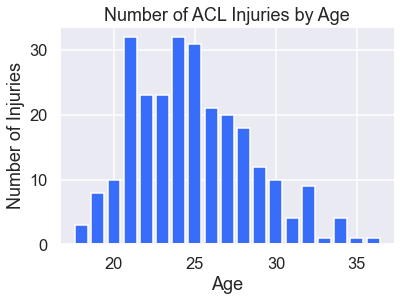

In [70]:
plt.bar(age_injury_counts['age'], age_injury_counts['counts'])
plt.xlabel('Age')
plt.ylabel('Number of Injuries')
plt.title('Number of ACL Injuries by Age')
plt.show()


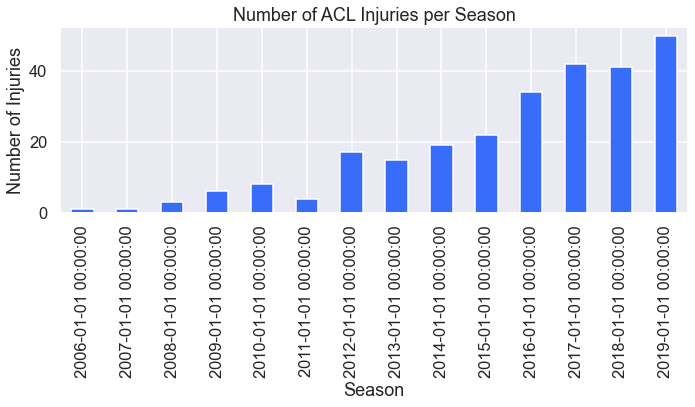

In [71]:
season_injury_counts = df_acl['season'].value_counts().sort_index()

# Plotting the data
season_injury_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Number of ACL Injuries per Season')
plt.ylabel('Number of Injuries')
plt.xlabel('Season')
plt.tight_layout()
plt.show()

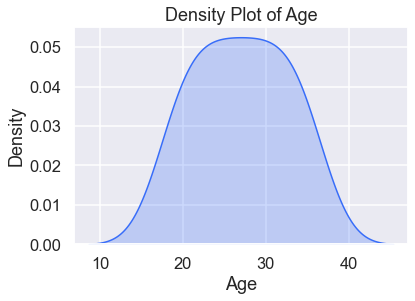

In [72]:
# Creating a density plot for 'age'
sns.kdeplot(age_injury_counts['age'], shade=True)
plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Density Plot of Age')
plt.show()

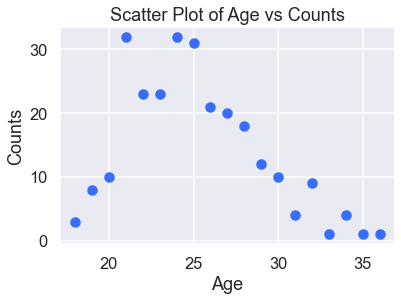

In [73]:
# Using the DataFrame 'df_age_injury_counts' created earlier
plt.scatter(age_injury_counts['age'], age_injury_counts['counts'])
plt.xlabel('Age')
plt.ylabel('Counts')
plt.title('Scatter Plot of Age vs Counts')
plt.show()

In [74]:
from scipy.stats import skew
data = age_injury_counts['counts']
skewness = skew(data)

print("Skewness: ", skewness)


Skewness:  0.4124289832889359


falls in the range between -0.5 and 0.5. This indicates that the distribution of the data is approximately symmetric and slightly skewed to the left . 

In [75]:
df_acl_orginal = df_acl

In [76]:
df_acl 

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2018-01-01,ACL,198,England,24
9,Benjamin Mendy,Manchester City,114000.0,1994-07-17,85,"1,85",France,Defender - Left-Back,left,2016-01-01,ACL,52,England,22
14,Ilkay Gündogan,Manchester City,114000.0,1990-10-24,78,"1,80",Germany,Midfielder - Central Midfield,right,2017-01-01,ACL,241,England,27
16,Fabian Delph,Manchester City,114000.0,1989-11-21,60,"1,74",England,Midfielder - Central Midfield,left,2010-01-01,ACL,248,England,21
28,Joe Gomez,Liverpool FC,95050.0,1997-05-23,77,"1,88",England,Defender - Centre-Back,right,2016-01-01,ACL,234,England,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526,Bebé,Rayo Vallecano,7130.0,1990-07-12,75,"1,90",Portugal,Forward - Left Winger,right,2012-01-01,ACL,227,Spain,22
2532,Yoel Rodríguez,Real Valladolid CF,6380.0,1988-08-28,78,"1,84",Spain,Goalkeeper,right,2017-01-01,ACL,214,Spain,29
2536,Nacho Martínez,Real Valladolid CF,6380.0,1989-03-07,70,"1,74",Spain,Defender - Left-Back,left,2013-01-01,ACL,42,Spain,24
2560,Pablo Insua,SD Huesca,4680.0,1993-09-09,75,"1,87",Spain,Defender - Centre-Back,right,2019-01-01,ACL,140,Spain,26


In [77]:
df_soccer

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017-01-01,Meniscal Injury,29,England,24
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019-01-01,Achilles tendon rupture,314,England,36
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017-01-01,Disrupted Calf Muscle,57,England,34
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Calf Injury,17,England,33
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016-01-01,Torn muscle bundle,24,England,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2016-01-01,Infection,7,Spain,22
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2015-01-01,Unknown Injury,12,Spain,21
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2019-01-01,Flu,7,Spain,20
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2018-01-01,Metatarsal Fracture,47,Spain,19


In [78]:
rows_with_nan = df_soccer[df_soccer.isna().any(axis=1)]
print(rows_with_nan)


Empty DataFrame
Columns: [name, club, club_value, birth, weight, height, country, role, foot, season, injury_type, days_injured, club_country, age]
Index: []


In [79]:
# Convert 'season' to numerical representation (extract year)
df_soccer['season'] = df_soccer['season'].dt.year

In [80]:
df_soccer

,name,club,club_value,birth,weight,height,country,role,foot,season,injury_type,days_injured,club_country,age
0,Ederson,Manchester City,114000.0,1993-08-17,89,"1,88",Brazil,Goalkeeper,left,2017,Meniscal Injury,29,England,24
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2019,Achilles tendon rupture,314,England,36
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2017,Disrupted Calf Muscle,57,England,34
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016,Calf Injury,17,England,33
1,Claudio Bravo,Manchester City,114000.0,1983-04-13,84,"1,84",Chile,Goalkeeper,right,2016,Torn muscle bundle,24,England,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2016,Infection,7,Spain,22
2577,Juanpi Añor,SD Huesca,4680.0,1994-01-24,65,"1,75",Venezuela,Forward - Right Winger,left,2015,Unknown Injury,12,Spain,21
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2019,Flu,7,Spain,20
2578,Cucho Hernández,SD Huesca,4680.0,1999-04-22,73,"1,76",Colombia,Forward - Centre-Forward,right,2018,Metatarsal Fracture,47,Spain,19


In [82]:
min_season = df_soccer['season'].min()
max_season = df_soccer['season'].max()

print("Range of values in 'season':", min_season, "to", max_season)


Range of values in 'season': 2006 to 2019


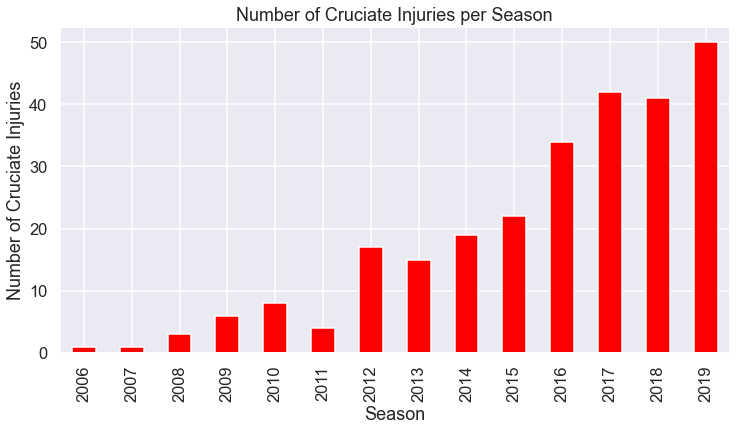

In [122]:
# Filter rows where injury type contains 'cruciate'
cruciate_injuries = df_soccer[df_soccer['injury_type'].str.contains('cruciate', case=False, na=False)]

# Count the occurrences for each season
season_counts = cruciate_injuries['season'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(12, 6))
season_counts.plot(kind='bar', color='red')
plt.title('Number of Cruciate Injuries per Season')
plt.xlabel('Season')
plt.ylabel('Number of Cruciate Injuries')
plt.show()

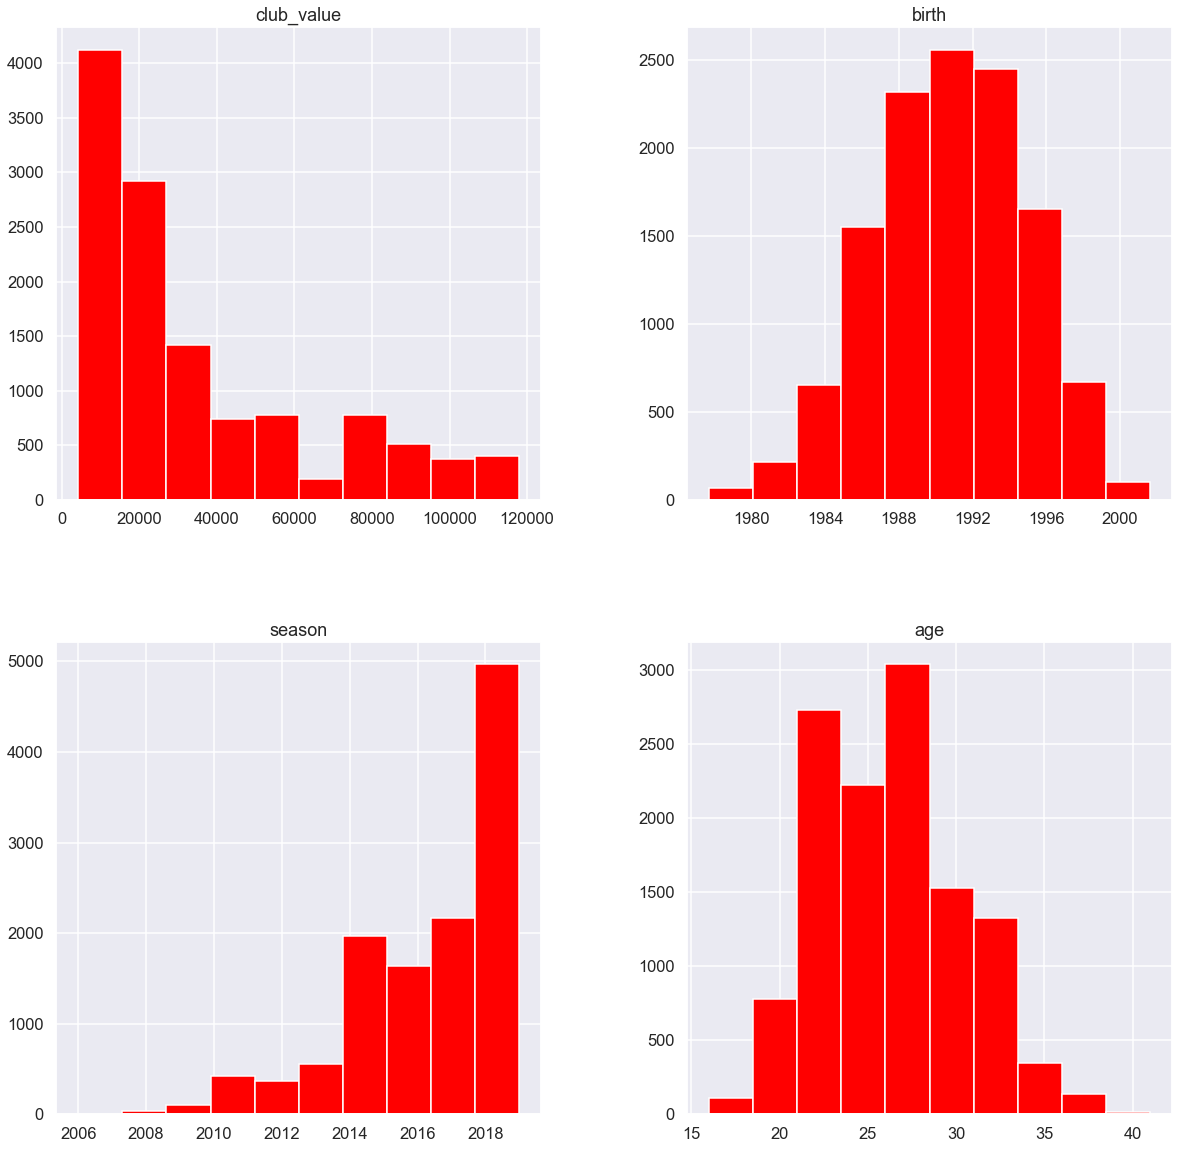

In [83]:
# visualize the feature distribution by plotting the histograms
# The gcf() function in pyplot module of matplotlib library is used to get the current Axes instance on the current figure 
# matching the given keyword args, or create one.

fig = plt.figure(figsize = (20,20))              # Size of the figure
ax = fig.gca()                                
df_soccer.hist(ax = ax, color = "red")                          # draw a histogram based on the dataset
plt.show()

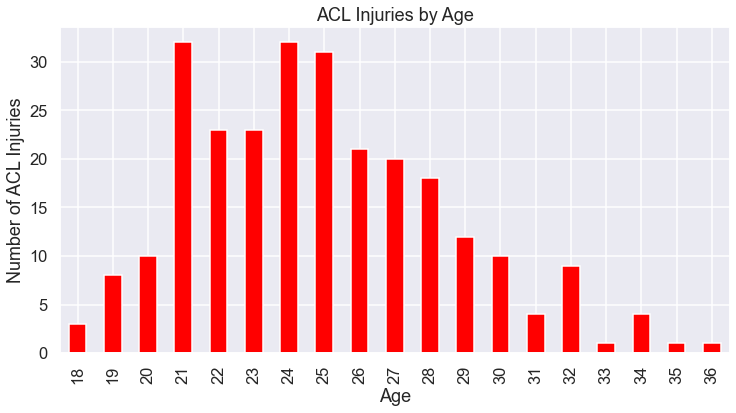

In [84]:
# Plotting for 'age'
age_counts = df_acl['age'].value_counts().sort_index()  # Sorting based on age
plt.figure(figsize=(12, 6))
age_counts.plot(kind='bar', color='red')
plt.title('ACL Injuries by Age')
plt.xlabel('Age')
plt.ylabel('Number of ACL Injuries')
plt.show()

In [85]:
import plotly.express as px 
import pywedge as pw 
mc = pw.Pywedge_Charts(df_soccer, c='injury_type', y="age")
charts=mc.make_charts()

HTML(value='<h2>Pywedge Make_Charts </h2>')

# Data prep for RFR

In [86]:
# Drop unnecessary columns, these columns wont be used for analysis
df_acl = df_soccer.drop(columns=['name', 'club', 'birth', 'country', 'season', 'days_injured'])

In [87]:
df_acl

,club_value,weight,height,role,foot,injury_type,club_country,age
0,114000.0,89,"1,88",Goalkeeper,left,Meniscal Injury,England,24
1,114000.0,84,"1,84",Goalkeeper,right,Achilles tendon rupture,England,36
1,114000.0,84,"1,84",Goalkeeper,right,Disrupted Calf Muscle,England,34
1,114000.0,84,"1,84",Goalkeeper,right,Calf Injury,England,33
1,114000.0,84,"1,84",Goalkeeper,right,Torn muscle bundle,England,33
...,...,...,...,...,...,...,...,...
2577,4680.0,65,"1,75",Forward - Right Winger,left,Infection,Spain,22
2577,4680.0,65,"1,75",Forward - Right Winger,left,Unknown Injury,Spain,21
2578,4680.0,73,"1,76",Forward - Centre-Forward,right,Flu,Spain,20
2578,4680.0,73,"1,76",Forward - Centre-Forward,right,Metatarsal Fracture,Spain,19


In [88]:
# Simplyifing postion
unique_roles = df_acl['role'].value_counts()
print(unique_roles)


Defender - Centre-Back             2408
Forward - Centre-Forward           1696
Midfielder - Central Midfield      1654
Midfielder - Defensive Midfield    1073
Defender - Right-Back              1057
Defender - Left-Back                956
Goalkeeper                          886
Forward - Left Winger               782
Forward - Right Winger              764
Midfielder - Attacking Midfield     573
Forward - Second Striker            186
Midfielder - Left Midfield          111
Midfielder - Right Midfield          77
Left-back / Wing-back                 2
Name: role, dtype: int64


In [89]:
def simplify_role(role):
    role_lower = role.lower()

    # Goalkeepers
    if 'goalkeeper' in role_lower:
        return 'Goalkeeper'
    
    # Defenders
    if any(sub in role_lower for sub in ['defender', 'centre-back', 'left-back', 'right-back', 'wing-back']):
        return 'Defender'
    
    # Midfielders
    if any(sub in role_lower for sub in ['midfield', 'central midfield', 'left-midfield', 'right-midfield', 'defensive midfield', 'attacking midfield']):
        return 'Midfielder'
    
    # Forwards
    if any(sub in role_lower for sub in ['forward', 'striker', 'winger', 'attacker', 'left-wing', 'right-wing']):
        return 'Forward'
    
    # If none of the above, return the original role (though ideally all should be captured in the above categories)
    return role

# Apply the function to the 'role' column in DataFrame
df_acl['role'] = df_acl['role'].apply(simplify_role)


In [90]:
unique_roles = df_acl['role'].value_counts()
print(unique_roles)

Defender      4423
Midfielder    3488
Forward       3428
Goalkeeper     886
Name: role, dtype: int64


## Converting to just acl and non acl

In [91]:
# Only intrested in ACL injuries 
#Replace any value in the 'injury_type' column containing the word 'cruciate' with 'ACL'
df_acl['injury_type'] = df_acl['injury_type'].apply(lambda x: 'ACL' if 'cruciate' in x.lower() else x)


In [92]:
df_acl

,club_value,weight,height,role,foot,injury_type,club_country,age
0,114000.0,89,"1,88",Goalkeeper,left,Meniscal Injury,England,24
1,114000.0,84,"1,84",Goalkeeper,right,Achilles tendon rupture,England,36
1,114000.0,84,"1,84",Goalkeeper,right,Disrupted Calf Muscle,England,34
1,114000.0,84,"1,84",Goalkeeper,right,Calf Injury,England,33
1,114000.0,84,"1,84",Goalkeeper,right,Torn muscle bundle,England,33
...,...,...,...,...,...,...,...,...
2577,4680.0,65,"1,75",Forward,left,Infection,Spain,22
2577,4680.0,65,"1,75",Forward,left,Unknown Injury,Spain,21
2578,4680.0,73,"1,76",Forward,right,Flu,Spain,20
2578,4680.0,73,"1,76",Forward,right,Metatarsal Fracture,Spain,19


In [93]:
df_acl.dtypes


club_value      float64
weight           object
height           object
role             object
foot             object
injury_type      object
club_country     object
age               int64
dtype: object

In [94]:
# Display rows with NaN values
rows_with_nan = df_acl[df_acl.isna().any(axis=1)]
print(rows_with_nan)


Empty DataFrame
Columns: [club_value, weight, height, role, foot, injury_type, club_country, age]
Index: []


In [95]:
# Find rows with hyphens in any columns
rows_with_hyphens = df_acl.apply(lambda row: any('-' in str(cell) for cell in row), axis=1)

# Print rows with hyphens
print(df_acl[rows_with_hyphens])


      club_value weight height        role   foot  \
40       95050.0     78  1,75   Midfielder  right   
1101     60230.0     71  1,86   Midfielder  right   

                             injury_type club_country  age  
40     Fracture-dislocation of the ankle      England   22  
1101   Fracture-dislocation of the ankle      Germany   23  


In [96]:
rows_with_hyphen = df_acl[df_acl.applymap(lambda x: x == '-').any(axis=1)]
print(rows_with_hyphen)


Empty DataFrame
Columns: [club_value, weight, height, role, foot, injury_type, club_country, age]
Index: []


In [120]:
df_acl

,club_value,weight,height,injury_type,age,role_Defender,role_Forward,role_Goalkeeper,role_Midfielder,foot_both,foot_left,foot_right,club_country_England,club_country_France,club_country_Germany,club_country_Italy,club_country_Spain
0,2.639061,2.064700,0.836866,0,24,0,0,1,0,0,1,0,1,0,0,0,0
1,2.639061,1.316092,0.218810,0,36,0,0,1,0,0,0,1,1,0,0,0,0
1,2.639061,1.316092,0.218810,0,34,0,0,1,0,0,0,1,1,0,0,0,0
1,2.639061,1.316092,0.218810,0,33,0,0,1,0,0,0,1,1,0,0,0,0
1,2.639061,1.316092,0.218810,0,33,0,0,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,-0.995378,-1.528617,-1.171817,0,22,0,1,0,0,0,1,0,0,0,0,0,1
2577,-0.995378,-1.528617,-1.171817,0,21,0,1,0,0,0,1,0,0,0,0,0,1
2578,-0.995378,-0.330845,-1.017303,0,20,0,1,0,0,0,0,1,0,0,0,0,1
2578,-0.995378,-0.330845,-1.017303,0,19,0,1,0,0,0,0,1,0,0,0,0,1


## Preparing for RFR

In [97]:
#Height contains unique values . They will be dropped and converted to cm 

In [98]:
df_acl['weight'] = df_acl['weight'].astype(int)


In [99]:
print(df_acl['height'].unique()) 

['1,88\xa0' '1,84\xa0' '1,91\xa0' '1,83\xa0' '1,90\xa0' '1,87\xa0'
 '1,85\xa0' '1,75\xa0' '1,79\xa0' '1,80\xa0' '1,74\xa0' '1,81\xa0'
 '1,70\xa0' '1,73\xa0' '1,93\xa0' '1,95\xa0' '1,78\xa0' '1,71\xa0'
 '1,72\xa0' '1,69\xa0' '1,86\xa0' '1,89\xa0' '1,82\xa0' '1,68\xa0'
 '1,77\xa0' '1,67\xa0' '1,92\xa0' '1,76\xa0' '1,94\xa0' '1,96\xa0'
 '1,97\xa0' '1,64\xa0' '1,98\xa0' '1,63\xa0' '2,01\xa0' '1,99\xa0'
 '1,65\xa0' 180]


Height contains unusual characters . They will be dropped by replacing them with an empty string .The comma will also be dropped. This converts to cm.  Then converted to float

In [100]:
#Convert heigh to string , replace comma with empty space(no space), esentially converting to cm 
#remove '\xa0' and convert to float (as height is technically continuos)
df_acl['height'] = df_acl['height'].astype(str).str.replace(',', '').str.rstrip('\xa0').astype(float)


In [101]:
#df_acl['height'] = df_acl['height'].astype(float)


In [102]:
print(df_acl['height'].unique()) 

[188. 184. 191. 183. 190. 187. 185. 175. 179. 180. 174. 181. 170. 173.
 193. 195. 178. 171. 172. 169. 186. 189. 182. 168. 177. 167. 192. 176.
 194. 196. 197. 164. 198. 163. 201. 199. 165.]


### Converting ACL and non ACL

In [103]:
# Replacing acl with 1 and everything else with 0
df_acl['injury_type'] = df_acl['injury_type'].apply(lambda x: 1 if x == 'ACL' else 0)


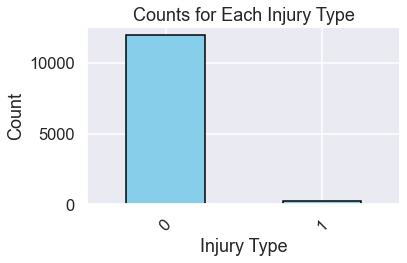

In [115]:
import matplotlib.pyplot as plt

# Calculate counts for each unique value in 'injury_type'
counts = df_acl['injury_type'].value_counts()

# Plot
counts.plot(kind='bar',color='skyblue', edgecolor='black')
plt.title('Counts for Each Injury Type')
plt.xlabel('Injury Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [116]:
print(counts)

0    11962
1      263
Name: injury_type, dtype: int64


The dataset is cleraly imbalanced 


In [105]:
df_acl['injury_type'] = df_acl['injury_type'].astype(int)

In [106]:
df_acl.dtypes

club_value      float64
weight            int32
height          float64
role             object
foot             object
injury_type       int32
club_country     object
age               int64
dtype: object

In [107]:
unique_foot_values = df_acl['foot'].unique()
print(unique_foot_values)


['left' 'right' 'both']


In [108]:
injury_type_counts = df_acl['injury_type'].value_counts()
print(injury_type_counts)


0    11962
1      263
Name: injury_type, dtype: int64


In [109]:
df_acl

,club_value,weight,height,role,foot,injury_type,club_country,age
0,114000.0,89,188.0,Goalkeeper,left,0,England,24
1,114000.0,84,184.0,Goalkeeper,right,0,England,36
1,114000.0,84,184.0,Goalkeeper,right,0,England,34
1,114000.0,84,184.0,Goalkeeper,right,0,England,33
1,114000.0,84,184.0,Goalkeeper,right,0,England,33
...,...,...,...,...,...,...,...,...
2577,4680.0,65,175.0,Forward,left,0,Spain,22
2577,4680.0,65,175.0,Forward,left,0,Spain,21
2578,4680.0,73,176.0,Forward,right,0,Spain,20
2578,4680.0,73,176.0,Forward,right,0,Spain,19


In [110]:
#he original columns 'role', 'foot', 'club_country' will be removed, and new dummy columns will be added in their place. 

# Encode categorical columns
df_acl = pd.get_dummies(df_acl, columns=['role', 'foot','club_country'])



Encoding categorical variables as numerical "dummy"  variables is an important preprocessing step for many machine learning algorithms, including Random Forest Regressors (RFR), Decision Trees, and k-Nearest Neighbors (kNN), which will be used in this analysis.

RFR and decision tree work more efficiently with categorical variables with increased accuracy . It is required for KNNas categorical data doesnt have a natural distance

With one-hot encoding, the feature importance analysis becomes easier to interpret,  can see the importance of each category within the feature.

This also needs to be done before scaling. 

In [111]:
df_acl

,club_value,weight,height,injury_type,age,role_Defender,role_Forward,role_Goalkeeper,role_Midfielder,foot_both,foot_left,foot_right,club_country_England,club_country_France,club_country_Germany,club_country_Italy,club_country_Spain
0,114000.0,89,188.0,0,24,0,0,1,0,0,1,0,1,0,0,0,0
1,114000.0,84,184.0,0,36,0,0,1,0,0,0,1,1,0,0,0,0
1,114000.0,84,184.0,0,34,0,0,1,0,0,0,1,1,0,0,0,0
1,114000.0,84,184.0,0,33,0,0,1,0,0,0,1,1,0,0,0,0
1,114000.0,84,184.0,0,33,0,0,1,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2577,4680.0,65,175.0,0,22,0,1,0,0,0,1,0,0,0,0,0,1
2577,4680.0,65,175.0,0,21,0,1,0,0,0,1,0,0,0,0,0,1
2578,4680.0,73,176.0,0,20,0,1,0,0,0,0,1,0,0,0,0,1
2578,4680.0,73,176.0,0,19,0,1,0,0,0,0,1,0,0,0,0,1


In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Select the columns to be standardised
columns_to_scale = ['club_value', 'weight', 'height']
df_acl[columns_to_scale] = scaler.fit_transform(df_acl[columns_to_scale])


Scaling data so that priority is not given to a particular feature in KNN but is not required for RFR and Decision Tree.  Scaling the features can speed up the training and convergence process for kNN and can result in a more accurate model Therefore all data will be scaled and used in this analysis


In [113]:
df_acl.to_csv('df_acl.csv', index=False)
